# Environmental setup

In [33]:
# %load ~/python/my_import.py
# BASIC
import numpy as np
import xarray as xr
import pandas as pd

#xr.set_options(display_style="text") # make it look better when posted online. Comment to get nicer representation of xarrays
import os
os.environ['HDF5_PLUGIN_PATH'] = '/work/bm0021/conda-envs/eerie_io/lib/python3.11/site-packages/hdf5plugin/plugins'

# matplotlib
import matplotlib
#%matplotlib inline
import matplotlib as mpl
import matplotlib.pylab as plt
import matplotlib.tri as mtri
import matplotlib.dates as md
import matplotlib.patches as patches
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from matplotlib import ticker
matplotlib.rcParams['figure.dpi'] = 80
matplotlib.rcParams['axes.linewidth'] = 1.5

## color
from matplotlib import cm
import cmocean
import seaborn as sns

## cartopy
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point


# scipy
from scipy import stats
from scipy import optimize
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
from scipy.stats import binned_statistic
import scipy.spatial.qhull as qhull


# metpy
import metpy
import metpy.calc as mpcalc


# etc
import subprocess
import time
import datetime
from datetime import timedelta
import calendar


# Dask
import dask # Distributed data libary
from dask import delayed
from dask import compute
from dask_jobqueue import SLURMCluster # Setting up distributed memories via slurm
from dask.utils import format_bytes
from distributed import Client, progress # Libaray to orchestrate distributed resources
from dask.distributed import Client
dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})

from pathlib import Path
from getpass import getuser # Libaray to copy things
from pathlib import Path # Object oriented libary to deal with paths
from tempfile import NamedTemporaryFile, TemporaryDirectory # Creating temporary Files/Dirs
import warnings
warnings.filterwarnings(action='ignore')

from matplotlib.dates import DateFormatter

In [2]:
def cut_region(model_lon, model_lat, elements, box):
    """
    Return mesh elements (triangles) and their indices corresponding to a bounding box.
    Parameters
    ----------
    model_lon : 1d numpy array
        longitudes of mesh vertices
    model_lat : 1d numpy array
        latitudes of mesh vertices
    box : list
        Coordinates of the box in [-180 180 -90 90] format.
    Returns
    -------
    elem_no_nan : array
        elements that belong to the region defined by the `box`.
    no_nan_triangles: array
        boolean array of element size with True for elements
        that belong to the `box`.
    """
    left, right, down, up = box

    selection = (
        (model_lon >= left)
        & (model_lon <= right)
        & (model_lat >= down)
        & (model_lat <= up)
    )

    elem_selection = selection[elements]

    no_nan_triangles = np.all(elem_selection, axis=1)

    elem_no_nan = elements[no_nan_triangles]

    return elem_no_nan, no_nan_triangles

def get_no_cyclic(model_lon, model_lat, elem_no_nan):
    """Compute non cyclic elements of the mesh."""
    d = model_lon[elem_no_nan].max(axis=1) - model_lon[elem_no_nan].min(axis=1)
    no_cyclic_elem = np.argwhere(d < 100)
    return no_cyclic_elem.ravel()


# Read data

### Grid

In [3]:
dpath = '/work/mh0731/m300793/grid-generator2/grids/'

gridICON = xr.open_mfdataset(f'{dpath}/icon_grid_0015_R02B09_germany.nc')
# gridICON = xr.open_mfdataset(f'{dpath}/icon_grid_0015_R02B09_germany2.nc')
gridICON

<xarray.Dataset>
Dimensions:                         (cell: 29143, nv: 3, vertex: 15073,
                                     edge: 44310, no: 4, nc: 2, ne: 6,
                                     max_chdom: 1, cell_grf: 14, edge_grf: 24,
                                     vert_grf: 13)
Coordinates:
    clon                            (cell) float64 dask.array<chunksize=(29143,), meta=np.ndarray>
    clat                            (cell) float64 dask.array<chunksize=(29143,), meta=np.ndarray>
    vlon                            (vertex) float64 dask.array<chunksize=(15073,), meta=np.ndarray>
    vlat                            (vertex) float64 dask.array<chunksize=(15073,), meta=np.ndarray>
    elon                            (edge) float64 dask.array<chunksize=(44310,), meta=np.ndarray>
    elat                            (edge) float64 dask.array<chunksize=(44310,), meta=np.ndarray>
Dimensions without coordinates: cell, nv, vertex, edge, no, nc, ne, max_chdom,
                                cell_grf, edge_grf, vert_grf
Data variables: (12/79)
    clon_vertices                   (cell, nv) float64 dask.array<chunksize=(29143, 3), meta=np.ndarray>
    clat_vertices                   (cell, nv) float64 dask.array<chunksize=(29143, 3), meta=np.ndarray>
    elon_vertices                   (edge, no) float64 dask.array<chunksize=(44310, 4), meta=np.ndarray>
    elat_vertices                   (edge, no) float64 dask.array<chunksize=(44310, 4), meta=np.ndarray>
    cell_area                       (cell) float64 dask.array<chunksize=(29143,), meta=np.ndarray>
    dual_area                       (vertex) float64 dask.array<chunksize=(15073,), meta=np.ndarray>
    ...                              ...
    edge_dual_normal_cartesian_x    (edge) float64 dask.array<chunksize=(44310,), meta=np.ndarray>
    edge_dual_normal_cartesian_y    (edge) float64 dask.array<chunksize=(44310,), meta=np.ndarray>
    edge_dual_normal_cartesian_z    (edge) float64 dask.array<chunksize=(44310,), meta=np.ndarray>
    cell_circumcenter_cartesian_x   (cell) float64 dask.array<chunksize=(29143,), meta=np.ndarray>
    cell_circumcenter_cartesian_y   (cell) float64 dask.array<chunksize=(29143,), meta=np.ndarray>
    cell_circumcenter_cartesian_z   (cell) float64 dask.array<chunksize=(29143,), meta=np.ndarray>
Attributes: (12/34)
    title:                    ICON grid description
    institution:              Max Planck Institute for Meteorology/Deutscher ...
    source:                   git@gitlab.dkrz.de:mpim-sw/grid-generator.git
    revision:                 13d76f3c73c9aca4188ef0cafd62c664b83cfb8a
    history:                  /work/mh0731/m300793/grid-generator2/bin/grid_c...
    date:                     20240110 at 154950
    ...                       ...
    mean_cell_area:           24323517.809282698
    mean_dual_cell_area:      48647026.33989711
    domain_length:            40031612.44147649
    domain_height:            40031612.44147649
    sphere_radius:            6371229.0
    domain_cartesian_center:  [0. 0. 0.]

In [4]:
vlon, vlat  = gridICON['vlon'].values*180./np.pi, gridICON['vlat'].values*180./np.pi
clon, clat  = gridICON['clon'].values*180./np.pi, gridICON['clat'].values*180./np.pi
elements    = gridICON.vertex_of_cell[:,:].T.values-1

points = np.vstack((clon, clat)).T

### bc_land_frac.nc

In [5]:
dpath = '/work/mh0731/m300793/data/landuse/'

fracESA = xr.open_mfdataset(f'{dpath}/ESA_CCI_11PFTs_8_EU.nc')
# fracESA = xr.open_mfdataset(f'{dpath}/ESA_CCI_11PFTs_8_germany2.nc')
fracESA

<xarray.Dataset>
Dimensions:      (cell: 279900, nv: 3)
Coordinates:
    clon         (cell) float64 dask.array<chunksize=(279900,), meta=np.ndarray>
    clat         (cell) float64 dask.array<chunksize=(279900,), meta=np.ndarray>
Dimensions without coordinates: cell, nv
Data variables: (12/13)
    clon_bnds    (cell, nv) float64 dask.array<chunksize=(279900, 3), meta=np.ndarray>
    clat_bnds    (cell, nv) float64 dask.array<chunksize=(279900, 3), meta=np.ndarray>
    fract_pft01  (cell) float64 dask.array<chunksize=(279900,), meta=np.ndarray>
    fract_pft02  (cell) float64 dask.array<chunksize=(279900,), meta=np.ndarray>
    fract_pft03  (cell) float64 dask.array<chunksize=(279900,), meta=np.ndarray>
    fract_pft04  (cell) float64 dask.array<chunksize=(279900,), meta=np.ndarray>
    ...           ...
    fract_pft06  (cell) float64 dask.array<chunksize=(279900,), meta=np.ndarray>
    fract_pft07  (cell) float64 dask.array<chunksize=(279900,), meta=np.ndarray>
    fract_pft08  (cell) float64 dask.array<chunksize=(279900,), meta=np.ndarray>
    fract_pft09  (cell) float64 dask.array<chunksize=(279900,), meta=np.ndarray>
    fract_pft10  (cell) float64 dask.array<chunksize=(279900,), meta=np.ndarray>
    fract_pft11  (cell) float64 dask.array<chunksize=(279900,), meta=np.ndarray>
Attributes: (12/42)
    CDI:                        Climate Data Interface version 2.2.4 (https:/...
    Conventions:                CF-1.6
    uuidOfHGrid:                b1106b54-c45b-11ee-8367-4fb6911d3de6
    source:                     MERIS FR L1B version 5.05, MERIS RR L1B versi...
    institution:                UCLouvain
    id:                         ESACCI-LC-L4-LCCS-Map-300m-P1Y-2015-v2.0.7cds
    ...                         ...
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.002778
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.002778
    cdo_openmp_thread_number:   8
    CDO:                        Climate Data Operators version 2.2.2 (https:/...

##### Sanity check

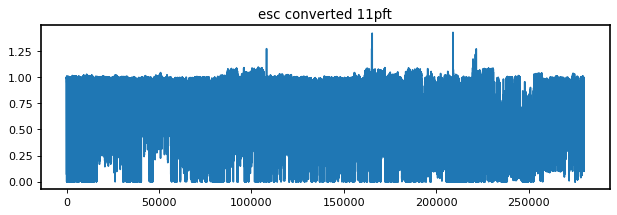

In [50]:
i_start, i_end = 0, -1

data_cut0 = fracESA .isel(cell=slice(i_start,i_end))

x = np.arange(i_start, i_end)

total_cut0 = np.zeros(data_cut0.dims['cell'])

rmax, cmax = 2, 2
fig, ax = plt.subplots(nrows=rmax,ncols=cmax, figsize=(15, 5),)

cmap = plt.cm.hsv

for pft in pft_list:
    # rr, cc = 0, 0
    # data_cut0[pft].plot(ax=ax[rr,cc], c=cmap([0.0]))
    total_cut0 = total_cut0 + data_cut0[pft].values

rr, cc = 0, 0
ax[rr,cc].set_title('esc converted 11pft')
# data_cut0['land'].plot(ax=ax[rr,cc], c='k')
ax[rr,cc].plot(total_cut0)
# leg=ax[rr,cc].legend(prop={'size': 13})

rr, cc = 0, 1
ax[rr,cc].set_visible(False)
rr, cc = 1, 0
ax[rr,cc].set_visible(False)
rr, cc = 1, 1
ax[rr,cc].set_visible(False)

plt.tight_layout()

In [6]:
dpath = '/work/mh0731/m300793/Carbon/land/EU/R02B09/0015/'
# dpath = '/work/mh0731/m300793/Carbon/land/germany2/R02B09/0015/'

fracICON = xr.open_mfdataset(f'{dpath}/bc_land_frac_11pfts_2015_EU.nc')
# fracICON = xr.open_mfdataset(f'{dpath}/bc_land_frac_11pfts_2015_germany2.nc')
fracICON

<xarray.Dataset>
Dimensions:        (cell: 279900, nv: 3)
Coordinates:
    clon           (cell) float64 dask.array<chunksize=(279900,), meta=np.ndarray>
    clat           (cell) float64 dask.array<chunksize=(279900,), meta=np.ndarray>
Dimensions without coordinates: cell, nv
Data variables: (12/23)
    clon_bnds      (cell, nv) float64 dask.array<chunksize=(279900, 3), meta=np.ndarray>
    clat_bnds      (cell, nv) float64 dask.array<chunksize=(279900, 3), meta=np.ndarray>
    notsea         (cell) float64 dask.array<chunksize=(279900,), meta=np.ndarray>
    fract_glac     (cell) float64 dask.array<chunksize=(279900,), meta=np.ndarray>
    sea            (cell) float64 dask.array<chunksize=(279900,), meta=np.ndarray>
    fract_lake     (cell) float64 dask.array<chunksize=(279900,), meta=np.ndarray>
    ...             ...
    fract_pft09    (cell) float64 dask.array<chunksize=(279900,), meta=np.ndarray>
    fract_pft10    (cell) float64 dask.array<chunksize=(279900,), meta=np.ndarray>
    fract_pft11    (cell) float64 dask.array<chunksize=(279900,), meta=np.ndarray>
    land           (cell) float64 dask.array<chunksize=(279900,), meta=np.ndarray>
    lake           (cell) float64 dask.array<chunksize=(279900,), meta=np.ndarray>
    glac           (cell) float64 dask.array<chunksize=(279900,), meta=np.ndarray>
Attributes: (12/44)
    CDI:                      Climate Data Interface version 2.2.4 (https://m...
    Conventions:              CF-1.6
    uuidOfHGrid:              cf4ad4e8-c03b-11ee-b366-6d425f42f60c
    title:                    ICON grid description
    revision:                 d00fcac1f61fa16c686bfe51d1d8eddd09296cb5
    date:                     20180529 at 222250
    ...                       ...
    subcentre:                1
    ICON_grid_file_uri:       http://icon-downloads.mpimet.mpg.de/grids/publi...
    comment:                   setup for an experiment with ocean model: grid...
    history:                  Mon Feb 05 20:59:09 2024: cdo remapnn,icon_grid...
    NCO:                      netCDF Operators version 5.0.6 (Homepage = http...
    CDO:                      Climate Data Operators version 2.2.2 (https://m...

In [7]:
fracICON_bc = fracICON.copy(deep=True)

# Overwrite

In [8]:
max_pft = 11
pft_list = []
for pft in np.arange(1, max_pft+1):
    pft_list.append('fract_pft'+'{:02d}'.format(pft))

In [9]:
# fracICON_backup = {}
# for pft in pft_list:
#     fracICON_backup[pft] = fracICON[pft].values

# for pft in pft_list:
#     fracICON[pft] = fracESA[pft]

In [10]:
fracICON01_backup = fracICON['fract_pft01'].values 
fracICON02_backup = fracICON['fract_pft02'].values
fracICON03_backup = fracICON['fract_pft03'].values
fracICON04_backup = fracICON['fract_pft04'].values
fracICON05_backup = fracICON['fract_pft05'].values
fracICON06_backup = fracICON['fract_pft06'].values
fracICON07_backup = fracICON['fract_pft07'].values
fracICON08_backup = fracICON['fract_pft08'].values
fracICON09_backup = fracICON['fract_pft09'].values
fracICON10_backup = fracICON['fract_pft10'].values
fracICON11_backup = fracICON['fract_pft11'].values

In [11]:
fracICON['fract_pft01'] = fracESA['fract_pft01']
fracICON['fract_pft02'] = fracESA['fract_pft02']
fracICON['fract_pft03'] = fracESA['fract_pft03']
fracICON['fract_pft04'] = fracESA['fract_pft04']
fracICON['fract_pft05'] = fracESA['fract_pft05']
fracICON['fract_pft06'] = fracESA['fract_pft06']
fracICON['fract_pft07'] = fracESA['fract_pft07']
fracICON['fract_pft08'] = fracESA['fract_pft08']
fracICON['fract_pft09'] = fracESA['fract_pft09']
fracICON['fract_pft10'] = fracESA['fract_pft10']
fracICON['fract_pft11'] = fracESA['fract_pft11']

### Correction
Correct where total fraction is greater than bc_land_frac_11pfts_2015.nc

In [93]:
max_pft = 11
pft_list = []
for pft in np.arange(1, max_pft+1):
    pft_list.append('fract_pft'+'{:02d}'.format(pft))

In [94]:
ncells = fracICON_bc.dims['cell']
total_EU, total_bc = np.zeros(ncells), np.zeros(ncells)

for pft in pft_list:
    EU_pft_temp = fracICON[pft].values
    bc_pft_temp = fracICON_bc[pft].values
    for i in np.arange(ncells):
        total_EU[i] = total_EU[i] + EU_pft_temp[i]
        total_bc[i] = total_bc[i] + bc_pft_temp[i]

In [95]:
fracICON_correct, fracICON_bc_correct = {}, {}
for pft in pft_list:
    fracICON_correct[pft] = fracICON[pft].values
    fracICON_bc_correct[pft] = fracICON_bc[pft].values

In [96]:
# !pip install tqdm
# from tqdm import tqdm

In [97]:
for i in tqdm(np.arange(ncells)):
    if total_bc[i] < total_EU[i]:
        # print(i, 'ESA is too larger', total_bc[i], total_EU[i])
        if total_EU[i] <= 0:
            raise Exception("1. devided by 0", i, total_bc[i], total_EU[i])

        correct_rate = total_bc[i]/total_EU[i]
        for pft in pft_list:
            fracICON_correct[pft][i] = fracICON_correct[pft][i] * correct_rate
            
    elif total_bc[i] > total_EU[i]:
        # print(i, 'ESA is too small', total_bc[i], total_EU[i])
        if total_EU[i] <= 0:
            # raise Exception("2. devided by 0", i, total_bc[i], total_EU[i])
            for pft in pft_list:
                fracICON_correct[pft][i] = fracICON_bc_correct[pft][i]
        else:
            correct_rate = total_bc[i]/total_EU[i]
            for pft in pft_list:
                fracICON_correct[pft][i] = fracICON_correct[pft][i] * correct_rate
    

 24%|██▍       | 67846/279900 [00:00<00:00, 226603.97it/s]

100%|██████████| 279900/279900 [00:01<00:00, 224993.37it/s]


In [108]:
for pft in pft_list:
    fracICON[pft] = (['cell'], fracICON_correct[pft])

### Sanity check

In [109]:
data_cut0 = fracICON_bc_correct
data_cut1 = fracICON_correct
data_cut2 = fracICON

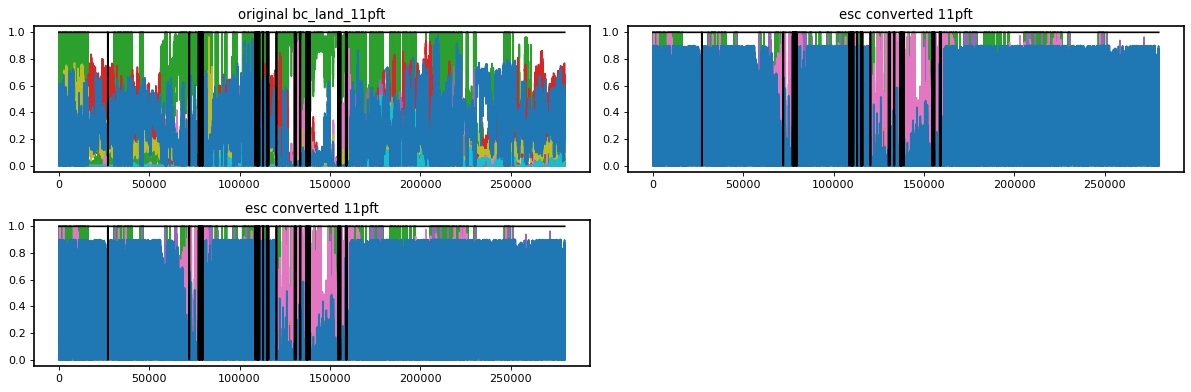

In [110]:
total_cut0 = np.zeros(279900)
total_cut1 = np.zeros(279900)
total_cut2 = np.zeros(279900)

rmax, cmax = 2, 2
fig, ax = plt.subplots(nrows=rmax,ncols=cmax, figsize=(15, 5),)

cmap = plt.cm.hsv

for pft in pft_list:
    rr, cc = 0, 0
    ax[rr,cc].plot(data_cut0[pft], label=pft)
    total_cut0 = total_cut0 + data_cut0[pft] #.values
    rr, cc = 0, 1
    ax[rr,cc].plot(data_cut1[pft])
    total_cut1 = total_cut1 + data_cut1[pft] #.values
    rr, cc = 1, 0
    ax[rr,cc].plot(data_cut2[pft])
    total_cut2 = total_cut2 + data_cut2[pft] #.values

rr, cc = 0, 0
ax[rr,cc].set_title('original bc_land_11pft')
# data_cut0['land'].plot(ax=ax[rr,cc], c='k')
ax[rr,cc].plot(total_cut0, c='k')
# leg=ax[rr,cc].legend(prop={'size': 13})

rr, cc = 0, 1
ax[rr,cc].set_title('esc converted 11pft')
# data_cut1['land'].plot(ax=ax[rr,cc], c='k')
ax[rr,cc].plot(total_cut1, c='k')

rr, cc = 1, 0
ax[rr,cc].set_title('esc converted 11pft')
# data_cut1['land'].plot(ax=ax[rr,cc], c='k')
ax[rr,cc].plot(total_cut2, c='k')

rr, cc = 1, 1
ax[rr,cc].set_visible(False)

plt.tight_layout()

In [111]:
dpath_out = dpath
fracICON.to_netcdf(f'{dpath_out}/bc_land_frac_11pfts_2015_EU_ESA_CCI_v2.nc', mode='w')
# fracICON.to_netcdf(f'{dpath_out}/bc_land_frac_11pfts_2015_germany2_ESA_CCI.nc', mode='w')

# Process

In [112]:
fracICON01 = fracICON['fract_pft01'].values 
fracICON02 = fracICON['fract_pft02'].values
fracICON03 = fracICON['fract_pft03'].values
fracICON04 = fracICON['fract_pft04'].values
fracICON05 = fracICON['fract_pft05'].values
fracICON06 = fracICON['fract_pft06'].values
fracICON07 = fracICON['fract_pft07'].values
fracICON08 = fracICON['fract_pft08'].values
fracICON09 = fracICON['fract_pft09'].values
fracICON10 = fracICON['fract_pft10'].values
fracICON11 = fracICON['fract_pft11'].values

# 1'Tropical broadleaf evergreen',
# 2'Tropical broadleaf deciduous',
# 3'Extra-tropical evergreen',    
# 4'Extra-tropical deciduous',    
# 5'Raingreen shrubs',            
# 6'Deciduous shrubs',            
# 7'C3 grass',                    
# 8'C4 grass',                    
# 9'C3 pasture',                  
# 10'C4 pasture',                  
# 11'C3 crops'                   

In [113]:
combined_frac = np.stack((fracICON01, fracICON02, fracICON03, fracICON04, fracICON05,
                          fracICON06, fracICON07, fracICON08, fracICON09, fracICON10, fracICON11,
                          ), axis=0)

total_frac  = np.sum(combined_frac, axis=0)
argmax_frac = np.argmax(combined_frac, axis=0)
land_frac   = fracICON['fract_land'].values
veg_frac    = fracICON['fract_veg'].values
gla_frac    = fracICON['fract_glac'].values

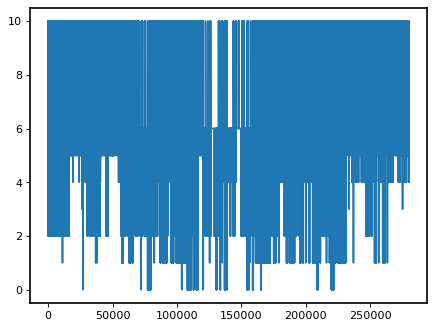

In [114]:
plt.plot(argmax_frac)

In [115]:
fracICON_new = fracICON.copy(deep=True)

In [116]:
fracICON_new = fracICON.copy(deep=True)
size = fracICON['cell'].size

frac01, frac02, frac03, frac04, frac05, = np.zeros(size), np.zeros(size), np.zeros(size), np.zeros(size), np.zeros(size)
frac06, frac07, frac08, frac09, frac10, frac11 = np.zeros(size), np.zeros(size), np.zeros(size), np.zeros(size), np.zeros(size), np.zeros(size)

max_value = 1.0 - 1.e-10 * 10
min_value = 1.e-10

for ii in np.arange(size):
    if total_frac[ii] > 0.0:
        argmax = int(argmax_frac[ii] + 1)
        
        match argmax:
            case 1:
                frac01[ii] = 1
            case 2:
                frac02[ii] = 1
            case 3:
                frac03[ii] = 1
            case 4:
                frac04[ii] = 1
            case 5:
                frac05[ii] = 1
            case 6:
                frac06[ii] = 1
            case 7:
                frac07[ii] = 1
            case 8:
                frac08[ii] = 1
            case 9:
                frac09[ii] = 1
            case 10:
                frac10[ii] = 1
            case 11:
                frac11[ii] = 1
            case _:
                ValueError("NO max point")
        
    else:
        if veg_frac[ii] == 0:
            frac01[ii], frac02[ii], frac03[ii], frac04[ii], frac05[ii]             = 0, 0, 0, 0, 0
            frac06[ii], frac07[ii], frac08[ii], frac09[ii], frac10[ii], frac11[ii] = 0, 0, 0, 0, 0, 0
            # print(ii, total_frac[ii], land_frac[ii], veg_frac[ii], gla_frac[ii], fracICON01[ii], fracICON02[ii], fracICON03[ii], fracICON04[ii], fracICON05[ii],)
            # print( fracICON06[ii], fracICON07[ii], fracICON08[ii], fracICON09[ii], fracICON10[ii],fracICON11[ii] )
        else:
            frac01[ii], frac02[ii], frac03[ii], frac04[ii], frac05[ii]             = fracICON01_backup[ii], fracICON02_backup[ii], fracICON03_backup[ii], fracICON04_backup[ii], fracICON05_backup[ii]
            frac06[ii], frac07[ii], frac08[ii], frac09[ii], frac10[ii], frac11[ii] = fracICON06_backup[ii], fracICON07_backup[ii], fracICON08_backup[ii], fracICON09_backup[ii], fracICON10_backup[ii], fracICON11_backup[ii]
            print(ii, total_frac[ii], land_frac[ii], veg_frac[ii], gla_frac[ii], np.sum([frac01[ii], frac02[ii], frac03[ii], frac04[ii], frac05[ii], frac06[ii], frac07[ii], frac08[ii], frac09[ii], frac10[ii], frac11[ii]]))
        continue
    
fracICON_new['fract_pft01'] = xr.where( frac01 == 1, fracICON_new['fract_pft01'] - fracICON_new['fract_pft01'] + max_value, min_value)
fracICON_new['fract_pft02'] = xr.where( frac02 == 1, fracICON_new['fract_pft01'] - fracICON_new['fract_pft01'] + max_value, min_value)
fracICON_new['fract_pft03'] = xr.where( frac03 == 1, fracICON_new['fract_pft01'] - fracICON_new['fract_pft01'] + max_value, min_value)
fracICON_new['fract_pft04'] = xr.where( frac04 == 1, fracICON_new['fract_pft01'] - fracICON_new['fract_pft01'] + max_value, min_value)
fracICON_new['fract_pft05'] = xr.where( frac05 == 1, fracICON_new['fract_pft01'] - fracICON_new['fract_pft01'] + max_value, min_value)
fracICON_new['fract_pft06'] = xr.where( frac06 == 1, fracICON_new['fract_pft01'] - fracICON_new['fract_pft01'] + max_value, min_value)
fracICON_new['fract_pft07'] = xr.where( frac07 == 1, fracICON_new['fract_pft01'] - fracICON_new['fract_pft01'] + max_value, min_value)
fracICON_new['fract_pft08'] = xr.where( frac08 == 1, fracICON_new['fract_pft01'] - fracICON_new['fract_pft01'] + max_value, min_value)
fracICON_new['fract_pft09'] = xr.where( frac09 == 1, fracICON_new['fract_pft01'] - fracICON_new['fract_pft01'] + max_value, min_value)
fracICON_new['fract_pft10'] = xr.where( frac10 == 1, fracICON_new['fract_pft01'] - fracICON_new['fract_pft01'] + max_value, min_value)
fracICON_new['fract_pft11'] = xr.where( frac11 == 1, fracICON_new['fract_pft01'] - fracICON_new['fract_pft01'] + max_value, min_value)

# Sanity check plot

In [117]:
# i_start, i_end = 1900, 2000
i_start, i_end = 0, -1

data_cut0 = fracICON_bc .isel(cell=slice(i_start,i_end))
data_cut1 = fracICON    .isel(cell=slice(i_start,i_end))
data_cut2 = fracICON_new.isel(cell=slice(i_start,i_end))

x = np.arange(i_start, i_end)


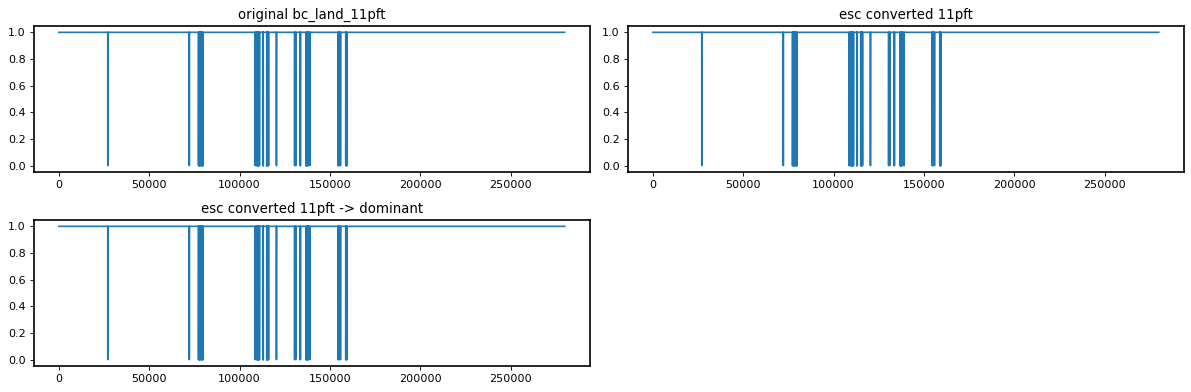

In [118]:
total_cut0 = np.zeros(data_cut0.dims['cell'])
total_cut1 = np.zeros(data_cut1.dims['cell'])
total_cut2 = np.zeros(data_cut2.dims['cell'])

rmax, cmax = 2, 2
fig, ax = plt.subplots(nrows=rmax,ncols=cmax, figsize=(15, 5),)

cmap = plt.cm.hsv

for pft in pft_list:
    # rr, cc = 0, 0
    # data_cut0[pft].plot(ax=ax[rr,cc], c=cmap([0.0]))
    total_cut0 = total_cut0 + data_cut0[pft].values
    # rr, cc = 0, 1
    # data_cut1[pft].plot(ax=ax[rr,cc], c=cmap([0.0]))
    total_cut1 = total_cut1 + data_cut1[pft].values
    # rr, cc = 1, 0
    # data_cut2[pft].plot(ax=ax[rr,cc], c=cmap([0.0]))
    total_cut2 = total_cut2 + data_cut2[pft].values

rr, cc = 0, 0
ax[rr,cc].set_title('original bc_land_11pft')
# data_cut0['land'].plot(ax=ax[rr,cc], c='k')
ax[rr,cc].plot(total_cut0)
# leg=ax[rr,cc].legend(prop={'size': 13})

rr, cc = 0, 1
ax[rr,cc].set_title('esc converted 11pft')
# data_cut1['land'].plot(ax=ax[rr,cc], c='k')
ax[rr,cc].plot(total_cut1)

rr, cc = 1, 0
ax[rr,cc].set_title('esc converted 11pft -> dominant')
# data_cut2['land'].plot(ax=ax[rr,cc], c='k')
ax[rr,cc].plot(total_cut2)

rr, cc = 1, 1
ax[rr,cc].set_visible(False)

plt.tight_layout()

In [120]:
i = 16
org, new = 0, 0
for pft in ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11']:
    org = org + data_cut0[f'fract_pft{pft}'].values[i]
    new = new + data_cut1[f'fract_pft{pft}'].values[i]
    print(f"pft: {pft}", data_cut0[f'fract_pft{pft}'].values[i], data_cut1[f'fract_pft{pft}'].values[i] )
    
print("lnd fract", data_cut0['land'].values[i], data_cut1['land'].values[i])
print(org, new)

pft: 01 9.999999999999999e-11 0.015705029847469604
pft: 02 9.999999999999999e-11 0.02917653516602564
pft: 03 0.07971991214757886 0.009016527637141157
pft: 04 0.059665522639157635 0.005883576593739928
pft: 05 9.999999999999999e-11 0.032589035817777605
pft: 06 0.008589746663981192 0.12889145330063617
pft: 07 9.999999999999999e-11 0.18320333189952667
pft: 08 9.999999999999999e-11 0.0
pft: 09 0.2850887381445188 0.0
pft: 10 9.999999999999999e-11 0.0
pft: 11 0.5669360798047633 0.5955345097376831
lnd fract 1.0 1.0
0.9999999999999999 0.9999999999999999


# Write

In [121]:
dpath_out = dpath
fracICON_new.to_netcdf(f'{dpath_out}/bc_land_frac_11pfts_2015_EU_ESA_CCI_dominant_v2.nc', mode='w')